In [413]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

def rmseFromResiduals(residuals):
    SSE = 0
    for i in range(len(residuals)):
        SSE += (residuals[i]**2)
    MSE = SSE/len(residuals)
    return math.sqrt(MSE)

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li> Analyze relationship between voter turnout and yellow improvement. Use linear regression to predict yellow improvement, given 60% voter turnout
<li> Check if all polls are useful and representative of the population.
<li> Simulate election using mean of purple share from the useful polls in a district. This will be the likelihood of one purple vote in a district.
<li> <b> What do you think about the error/accuracy:</b> See errors section below
</ul>

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [390]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns=["district"])

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head(7)

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53


##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [391]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns=["voter_turn_percentage"])
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head(10)

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017
5,0.59,-0.004,2018
6,0.49,-0.030,2019
7,0.57,0.042,2020
8,0.56,0.029,2021


## Start Your Work

### <b> Part 1 - Election </b>

##### Look at Relationship Between Voter Turnout and Yellow Improvement #####

<AxesSubplot:xlabel='voter_turn_percentage', ylabel='Yellow_improvement'>

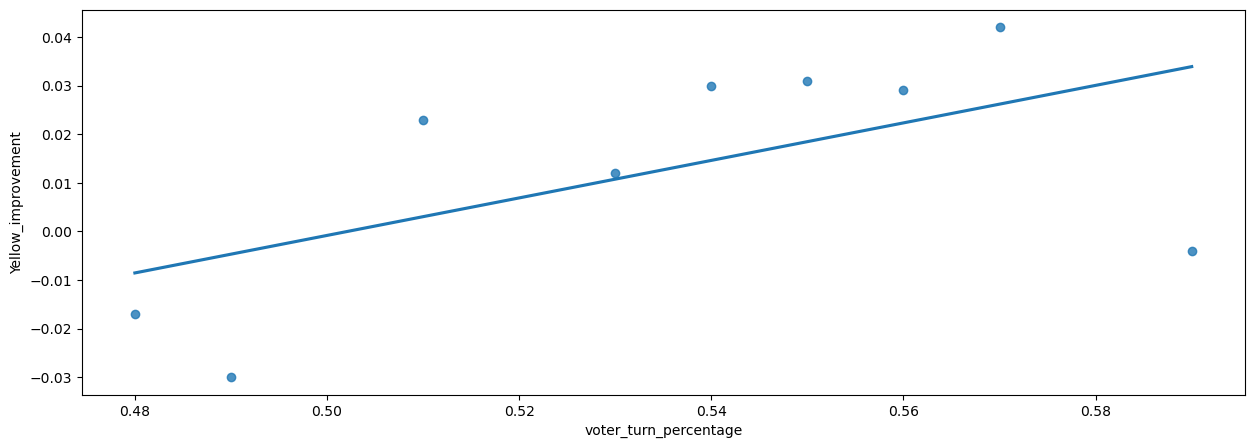

In [392]:
sns.regplot(y=past_vote_table['Yellow_improvement'], x=past_vote_table['voter_turn_percentage'], ci=0)

##### Linear Least Squares #####

In [393]:
inter2, slope2 = thinkstats2.LeastSquares(xs=past_vote_table["voter_turn_percentage"], ys=past_vote_table["Yellow_improvement"])
res2 = thinkstats2.Residuals(past_vote_table["voter_turn_percentage"], past_vote_table["Yellow_improvement"], inter2, slope2)
rmse = rmseFromResiduals(res2)
print("Y intercept:", inter2)
print("Slope:", slope2)
print("RMSE:", rmse)

Y intercept: -0.19374537987679685
Slope: 0.3858316221765916
RMSE: 0.018967303783676472


RMSE around 1.9%. Error from predicted Yellow improvement could really sway the election one way or the other. However, let's use the regression to predict yellow improvement using the predicted voter turnout

In [394]:
yellow_improve = slope2*0.60 + inter2
yellow_improve - rmse, yellow_improve, yellow_improve + rmse

(0.018786289645481628, 0.0377535934291581, 0.056720897212834576)

##### Are These Polls From the Same Population? #####

In [395]:
lev_stat, lev_p = ss.levene(dist_polls['Poll_1'], dist_polls['Poll_2'], dist_polls['Poll_3'], dist_polls['Poll_4'], dist_polls['Poll_5'], dist_polls['Poll_6'], dist_polls['Poll_7'])
anova_stat, anova_p = ss.f_oneway(dist_polls['Poll_1'], dist_polls['Poll_2'], dist_polls['Poll_3'], dist_polls['Poll_4'], dist_polls['Poll_5'], dist_polls['Poll_6'], dist_polls['Poll_7'])

print('Levene Test:', lev_p)
print('ANOVA:', anova_p)

Levene Test: 0.8144921531451352
ANOVA: 0.7097372305488329


Fairly likely the polls represent the same population. Let's use the average of the poll results in each district as an approximation for the likelihood of a Purple Vote for each district

##### Mean of Purple Share in Each District from the Polls #####

In [396]:
# Calculate mean of the poll results for each district

dist = dist_polls.T
dist = dist.iloc[1:,]
dist_means = [dist.iloc[:, i].mean() for i in range(7)]

for i in range(7):
    print('District', i+1, 'Mean:', dist_means[i])

District 1 Mean: 0.54
District 2 Mean: 0.4766666666666667
District 3 Mean: 0.51
District 4 Mean: 0.5988888888888889
District 5 Mean: 0.4511111111111111
District 6 Mean: 0.47333333333333333
District 7 Mean: 0.5322222222222223


##### Binomial Distribution for Simulation of 1 Vote in a District

In [397]:
# Binomial distribution to simulate one vote
# dist_prob is the probability that a voter will vote for purple in a particular district

def oneVote(dist_prob):
    vote_prob = np.random.binomial(n=1, p=dist_prob)
    return vote_prob

##### Simulate Race in a District #####

In [398]:
# Many simulated votes to predict Purple share in one district

def purpleShare(dist_prob, n=500):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(dist_prob))
    share = np.mean(vote_list)
    return share

##### Simulate Many Elections #####

In [399]:
# Simulate 1000 elections

def simulate_elections(distprobs, n=1000):
    election_simulations = [] # List of election simulations
    purple_wins = 0
    
    for i in range(n):
        purple_seats = 0
        
        for j in range(len(distprobs)):
            district_result = purpleShare(distprobs[j]) - yellow_improve # adjust for voter turnout here
            if district_result > 0.5:
                purple_seats += 1 # Count number of seats purple wins 

        if purple_seats >= 4: # Need at least 4 seats to win
            purple_wins += 1

        election_simulations.append(purple_seats)

    cdf = thinkstats2.Cdf(election_simulations) # many trials, number of seats likely follows normal distribution

    return purple_wins/n, election_simulations, cdf

purpleWinPercent, purpleSeats, purpleCdf = simulate_elections(dist_means)

{'xscale': 'linear', 'yscale': 'linear'}

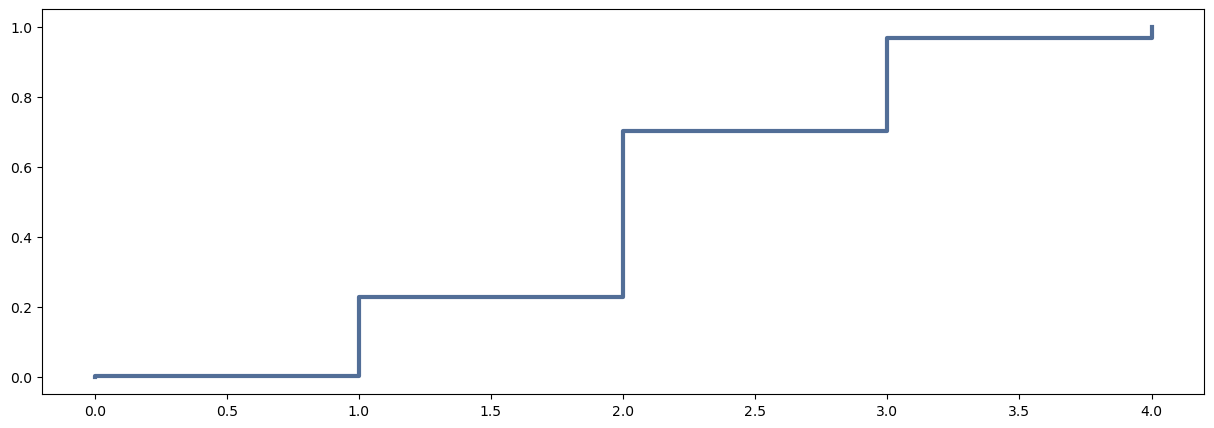

In [400]:
thinkplot.cdf(purpleCdf)

##### How Likely (or Unlikely) is Purple to Win?

In [401]:
lessthan3 = purpleCdf.PercentileRank(3)

print(f'Our simulations show that the Purple party wins {purpleWinPercent*100}% of the time ')
print(f'We are {lessthan3}% confident that the Purple Party will get between between 0 and 3 seats. It is highly likely that the Yellow Party will win.')

Our simulations show that the Purple party wins 3.2% of the time 
We are 96.8% confident that the Purple Party will get between between 0 and 3 seats. It is highly likely that the Yellow Party will win.


##### Errors #####

Our linear regression predicting the yellow improvement has an RMSE of about 1.9%. Judging by the polls, if the 2022 Yellow improvement had a residual of about 1.9% in either direction, the yellow improvement could range from 0.019 and 0.057 which could largely sway the predictions in one direction since the polling shows the Purple Share to be relatively close to 50% in many districts. Using the predicted Yellow improvement of 3.78% could largely sway the election toward the Yellow Party. 

Errors could also arise from using a mean of the polling data in each district to approximate the probability of each voter choosing purple. Though our ANOVA and Levene tests show a relatively high likelihood of these samples being of the same population, the samples may not be representative of all the people who are voting.

There could also be an error in the assumption that the distribution of the number of Purple seats in the simulations is normally distributed. There are only 7 values it could be. Perhaps we could establish a confidence interval for the Purple share in each district, however it would be more difficult to translate the confidence interval of each district into who wins the election overall.

### <b> Part 2 - Regression </b>

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li> Filter Out Outliers
<li> Split Data into Training and Testing
<li> Create Model using Training Data and Use Model to Make Predictions
<li> Evaluate Accuracy of Predictions and Usefulness of Model
</ul>

In [402]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


In [403]:
df.sort_values('wage_eur',ascending=False)

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
5,370000,93,82,55,92,82,86,85,83,91,...,90,76,61,88,94,79,91,68,58,51
22,370000,83,89,84,85,87,88,86,85,82,...,83,73,49,90,86,86,89,59,54,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0,10,8,11,18,8,9,9,18,16,...,7,34,23,27,71,14,67,12,17,13
1868,0,52,34,73,70,48,55,42,42,72,...,32,63,78,35,54,47,75,78,78,77
14723,0,62,27,44,59,25,51,30,29,59,...,29,50,55,47,34,37,45,43,68,65
16356,0,10,8,12,19,5,12,14,11,24,...,9,19,8,5,29,17,28,6,13,13


##### Remove Outliers #####

In [404]:
zerowage = df[df['wage_eur'] == 0]
zerowage.describe()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
count,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.00000,240.00000
mean,0.0,49.625000,44.654167,53.000000,58.070833,42.791667,53.258333,45.854167,43.50000,54.350000,...,46.775000,57.633333,48.350000,48.112500,53.504167,48.941667,60.570833,48.079167,48.47500,46.57500
std,0.0,20.230083,21.686845,20.432561,17.405068,20.332547,21.102656,20.251339,19.27059,16.653068,...,21.806092,19.217075,21.861163,21.605241,15.980374,17.348891,13.465405,23.095354,23.86572,23.73288
min,0.0,8.000000,5.000000,7.000000,11.000000,5.000000,6.000000,8.000000,7.00000,12.000000,...,4.000000,16.000000,6.000000,4.000000,12.000000,11.000000,13.000000,5.000000,7.00000,9.00000
25%,0.0,39.000000,26.750000,44.000000,52.000000,25.750000,41.250000,30.750000,30.00000,45.000000,...,27.000000,43.000000,26.000000,29.750000,42.000000,38.000000,53.000000,24.000000,24.00000,21.00000
50%,0.0,56.000000,45.000000,59.000000,64.000000,46.000000,60.000000,48.500000,44.50000,59.000000,...,51.500000,62.000000,55.000000,53.000000,57.000000,49.000000,63.500000,56.500000,58.00000,55.00000
75%,0.0,65.000000,64.000000,68.000000,70.000000,58.250000,70.000000,62.000000,59.25000,67.250000,...,65.000000,73.000000,68.000000,66.000000,66.000000,63.250000,70.000000,68.000000,69.25000,68.00000
max,0.0,83.000000,83.000000,86.000000,83.000000,82.000000,83.000000,87.000000,91.00000,82.000000,...,89.000000,90.000000,86.000000,84.000000,83.000000,86.000000,84.000000,85.000000,85.00000,82.00000


Looks like there are quite a few players with varying levels of skill earning 0 dollars. We should remove these since their skill doesn't really relate to to their wage.

In [405]:
df = df[df["wage_eur"] > 0]

##### Prepare Data for Creating Model #####

In [407]:
df_ = df.drop(columns=['wage_eur'])
x = np.array(df_)
y = np.array(df['wage_eur']).reshape(-1,1)
x.shape, y.shape

((18038, 29), (18038, 1))

In [408]:
xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=.2)

In [409]:
print(xTrain.shape, yTrain.shape)
print(xTest.shape, yTest.shape)

(14430, 29) (14430, 1)
(3608, 29) (3608, 1)


##### Create Model #####

In [410]:
#Generate model 
model = LinearRegression().fit(xTrain,yTrain)
print('Intercept:', model.intercept_[0])
print('Coefs:', model.coef_[0])

Intercept: -68135.5848725404
Coefs: [  10.96673504   39.49895658   -4.47987092   89.18401772   97.169769
   22.66397057   36.55924279  -50.75833437  -22.34741474   75.64103618
   36.02441393   59.83094923  -95.40328866  934.49768472  -48.15500728
  149.00661897   53.38307482 -106.48248802  -35.3196506  -195.50489022
  -62.68724319  -12.99182533 -100.89300405  138.42652788  -14.6139377
  229.42430492   -8.21895647   80.3677966   -20.35908109]


##### How Accurate and "Good" is Our Model? #####

In [411]:
tmp = model.predict(xTest)
tmp1 = pd.DataFrame(yTest, columns=["Y values"])
tmp2 = pd.DataFrame(tmp, columns=["Predictions"])
tmp3 = pd.DataFrame((yTest-tmp), columns=["Residual"])
resFrame = pd.concat([tmp1,tmp2,tmp3], axis=1)
resFrame.head()

,Y values,Predictions,Residual
0,3000,15764.768197,-12764.768197
1,4000,17661.234115,-13661.234115
2,2000,11070.103653,-9070.103653
3,10000,12131.925795,-2131.925795
4,10000,26072.051687,-16072.051687


In [412]:
r_sq = model.score(xTest, yTest)
rmse = mean_squared_error(tmp, yTest, squared=False)
print('R-squared:', r_sq)
print('RMSE:', rmse)

R-squared: 0.2934587692779096
RMSE: 17638.531577157548
